``` py

!pip install takeHomeTest
import takeHomeTest

!pip install time
from time import oneWeek as panic

panic.dump(takeHomeTest)


print("Welcome to your take home final!\n")
```

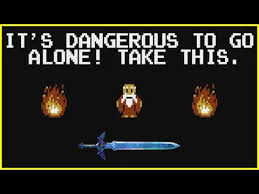




## ------------------------------------------- The Legend of Python --------------------------------------------
**Lore**

In the Kingdom of Pyrovia, all nations once traded in harmony. But since the Shattering of the Global APIs, the knowledge of currency exchange — locked away in XML scrolls — has scattered across the timelines. These scrolls reside in a mysterious repository known only as floatrates.com.

The High Council of Programmers has summoned you (and only you), young code-wielder, to begin your final trial. It is divided into 2 parts.
* Quest 1 (50xp): Retrieving the scrolls of time - Threading and Json save and parsing
* Quest 2 (50xp): Decipher the scrolls - Perform EDA on the data.

------ ------ ------ ------ Extra credit ------ ------ ------ ------ 
* Side Quest 1 (10xp*): Lay down seeds for those that follow - create error logs 
* Side Quest 2 (10xp*): The Quest of reflection  - Use profiling on your code to fully understand it 

*any points over 100% will be rolled over into your final grade. 

I may not have time to run all of your code so make sure you very clearly take notes and communicate successes, issues, and lessons learned. 
Please stay off Chat GPT and stack overflow (and like). You should have most everything you need in the notes. 

--------------------------------------------
# Quest 1 (50 xp): Retrieving the Scrolls of Time 
Retrieve historical exchange rate data from floatrates.com for one of the (Ideally randomly pick) 52 available currencies, starting from the first record on May 4, 2011, until the present day.

- You may store the data as-is in XML, or convert it to JSON, you may use the supplied code below as a starter. 

- Organize each currency into its own directory.

- Ensure your code is modular, maintainable, and robust against timeouts or malformed entries.

## Notes from the Grand Master 
* Threading is your ally. But do not burn out your ally as they have limited resources. You may use the threading or multi-core to parallelize downloads — but mind the server’s load. Around 10 threads is wise. 
    - You should have around 5040 queries.

* XML Scrolls is a new and unfamiliar beast. Therefore takeing on this beast will wield 5 extra experience points. You will not be penalized for choosing to use JSON

*  Use the Save. Nothing is worse than losing experience you have already gained. Save the raw XML (or converted JSON) using timestamped (in my example below) files so you do not need to look it up again. Ie. If you put in a start date and your program has already read that data it should not pull that date again. (it would be a good idea to delete your data and run it top to bottom before final submission)

* Design gracefully. Structure your project with clear modules: downloader.py, parser.py, and so on. 

* Log your quest progress in your quest book to show the Grand Master what you learned this is very important. 


--------------------------------------------

In [1]:
!pip install xmltodict

Defaulting to user installation because normal site-packages is not writeable


In [2]:
rates = ["EUR", "GBP", "USD", "DZD", "AUD", "BWP", "BND", "CAD", "CLP", "CNY", "COP", "CZK", "DKK", "HUF", "ISK", "INR", "IDR", "ILS", "KZT", "KRW", "KWD", "LYD", "MYR", "MUR", "NPR", "NZD", "NOK", "OMR", "PKR", "PLN", "QAR", "RUB", "SAR", "SGD", "ZAR", "LKR", "SEK", "CHF", "THB", "TTD"]
ratesForBase = [r for r in rates if r != "USD" and r != "EUR" and r != "GBP"]

In [2]:
import requests
import xmltodict
import json
import random
import threading
import logging
import time
from datetime import datetime, timedelta
from pathlib import Path
import concurrent.futures
from typing import List, Optional, Dict, Any


LOG_FILE = "exchange_rates_retriever.log"
BASE_DIR = "exchange_rates"
DATE_FORMAT = "%Y-%m-%d"
API_URL = "https://www.floatrates.com/historical-exchange-rates.html"
PB_ID = "1775"
FORMAT_TYPE = "xml"
MAX_THREADS = 10
SAVE_AS_JSON = True
REQUEST_TIMEOUT = 20
MAX_RETRIES = 3
RETRY_DELAY = 2
PROGRESS_UPDATE_INTERVAL = 50

def setup_logging() -> logging.Logger:

    """logging configuration"""

    logging.basicConfig(

        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[logging.StreamHandler(), logging.FileHandler(LOG_FILE)],

    )

    return logging.getLogger("ExchangeRatesRetriever")

logger = setup_logging()

def generate_date_range(start_date_str: str) -> List[str]:

    """list of dates until today"""

    start_date = datetime.strptime(start_date_str, DATE_FORMAT)
    end_date = datetime.now()

    date_list = [

        current_date.strftime(DATE_FORMAT)
        for current_date in (start_date + timedelta(n) for n in range(int((end_date - start_date).days) + 1))

    ]

    logger.info(

        f"Generated date range: {start_date_str} to {end_date.strftime(DATE_FORMAT)} "
        f"({len(date_list)} days)"

    )

    return date_list

def construct_api_url(date: str, base_currency: str) -> str:

    """api url contruction"""

    return (

        f"{API_URL}?operation=rates&pb_id={PB_ID}&page=historical"
        f"&currency_date={date}&base_currency_code={base_currency}&format_type={FORMAT_TYPE}"

    )

def get_file_extension() -> str:

    """file extension determination"""

    return "json" if SAVE_AS_JSON else "xml"

def get_file_path(
        
    date: str, base_currency: str, base_directory: Path
) -> Path: 
    
    """generates file path"""

    return base_directory / f"{date}_exchange_rates_{base_currency}.{get_file_extension()}"

def check_file_exists(
    
    date: str, base_currency: str, base_directory: Path
) -> bool: 
    
    """check if file exists"""

    return get_file_path(date, base_currency, base_directory).exists()

def parse_response(response: requests.Response) -> Dict[str, Any]:

    """parses the response"""

    return xmltodict.parse(response.text)

def save_data(data: Dict[str, Any], file_path: Path, response_text: str) -> None:

    """saves data to json or xml file"""

    if SAVE_AS_JSON:

        json_data = json.dumps(data, indent=4)

        with open(file_path, "w") as json_file:

            json_file.write(json_data)

    else:

        with open(file_path, "w") as xml_file:

            xml_file.write(response_text)

def download_exchange_rates(
    date: str, base_currency: str, base_directory: Path
) -> bool:
    
    """download exchange rates"""

    global successful_downloads, failed_downloads, skipped_downloads

    if check_file_exists(date, base_currency, base_directory):

        with counter_lock:

            skipped_downloads += 1

        logger.debug(f"Skipping {date}: File already exists")

        return True

    url = construct_api_url(date, base_currency)

    for attempt in range(MAX_RETRIES):

        try:
            response = requests.get(url, timeout=REQUEST_TIMEOUT)

            response.raise_for_status()

            data_dict = parse_response(response)

            save_data(data_dict, get_file_path(date, base_currency, base_directory), response.text)

            with counter_lock:

                successful_downloads += 1

            if successful_downloads % PROGRESS_UPDATE_INTERVAL == 0:

                logger.info(f"Successfully downloaded data for {successful_downloads} dates")

            return True

        except requests.exceptions.RequestException as e:

            logger.warning(f"Attempt {attempt + 1}/{MAX_RETRIES} failed for {date}: {e}")
            time.sleep(RETRY_DELAY * (attempt + 1))

        except xmltodict.ExpatError as e:
             
             logger.error(f"XML Parsing error for {date}: {e}")

             return False

    with counter_lock:

        failed_downloads += 1

    logger.error(f"Failed to download data for {date} after {MAX_RETRIES} attempts")

    return False


def main() -> None:

    """exchange rates data retriever main function"""

    global successful_downloads, failed_downloads, skipped_downloads, ratesForBase, counter_lock

    rates = ["USD", "EUR", "GBP", "JPY", "CAD", "AUD", "CHF"]
    
    ratesForBase = [r for r in rates if r not in ("USD", "EUR", "GBP")]

    base_currency = random.choice(ratesForBase)

    logger.info(f"Selected base currency: {base_currency}")

    base_directory = Path(BASE_DIR) / base_currency

    base_directory.mkdir(parents=True, exist_ok=True)

    logger.info("Exchange rates data retriever started")

    date_list = generate_date_range("2011-05-04")

    total_dates = len(date_list)

    logger.info(

        f"Starting download of {total_dates} days of exchange rate data for {base_currency}"

    )

    start_time = time.time()
    successful_downloads = 0
    failed_downloads = 0
    skipped_downloads = 0
    counter_lock = threading.Lock()

    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:

        futures = [

            executor.submit(download_exchange_rates, date, base_currency, base_directory)
            for date in date_list

        ]

        for i, future in enumerate(concurrent.futures.as_completed(futures)):

            progress = (i + 1) / total_dates * 100
            elapsed_time = time.time() - start_time

            if (i + 1) % PROGRESS_UPDATE_INTERVAL == 0 or (i + 1) == total_dates:

                logger.info(

                    f"Progress: {progress:.1f}% ({i + 1}/{total_dates}), "
                    f"Elapsed time: {elapsed_time:.1f}s"

                )

    end_time = time.time()
    total_time = end_time - start_time

    logger.info(f"Download complete. Total time: {total_time:.1f} seconds")
    logger.info(

        f"Summary: {successful_downloads} successful, {failed_downloads} failed, "
        f"{skipped_downloads} skipped"

    )

  
    analyze_sample_data(base_directory, base_currency)

def analyze_sample_data(base_directory: Path, base_currency: str) -> None:

    """sample data analysis"""

    sample_files = list(

        base_directory.glob(f"*_exchange_rates_{base_currency}.{get_file_extension()}")

    )

    if sample_files:

        sample_file = sample_files[0]
        logger.info(f"Sample file: {sample_file}")

        try:
            with open(sample_file, "r") as f:

                data = json.load(f)
            logger.info(f"Sample data structure: {list(data.keys())}")

            if "rates" in data and "item" in data["rates"]:

                items = data["rates"]["item"]

                if isinstance(items, list):

                    logger.info(f"Number of currencies in sample: {len(items)}")

                else:

                    logger.info("Sample contains a single currency rate")

        except (FileNotFoundError, json.JSONDecodeError) as e:

            logger.error(f"Error analyzing sample file: {e}")

if __name__ == "__main__":

    try:
        main()

    except KeyboardInterrupt:

        logger.warning("Program interrupted by user")

    except Exception as e:

        logger.error(f"An error occurred: {e}")
        
        raise

2025-05-16 11:34:56,929 - ExchangeRatesRetriever - INFO - Selected base currency: CHF
2025-05-16 11:34:56,930 - ExchangeRatesRetriever - INFO - Exchange rates data retriever started
2025-05-16 11:34:56,942 - ExchangeRatesRetriever - INFO - Generated date range: 2011-05-04 to 2025-05-16 (5127 days)
2025-05-16 11:34:56,942 - ExchangeRatesRetriever - INFO - Starting download of 5127 days of exchange rate data for CHF
2025-05-16 11:34:58,822 - ExchangeRatesRetriever - INFO - Successfully downloaded data for 50 dates
2025-05-16 11:34:58,826 - ExchangeRatesRetriever - INFO - Progress: 1.0% (50/5127), Elapsed time: 1.9s
2025-05-16 11:35:00,639 - ExchangeRatesRetriever - INFO - Successfully downloaded data for 100 dates
2025-05-16 11:35:00,649 - ExchangeRatesRetriever - INFO - Progress: 2.0% (100/5127), Elapsed time: 3.7s
2025-05-16 11:35:02,441 - ExchangeRatesRetriever - INFO - Successfully downloaded data for 150 dates
2025-05-16 11:35:02,444 - ExchangeRatesRetriever - INFO - Progress: 2.9% 

--------------------------------------------
# Quest 2 (50 XP): Decipher the scrolls – Exploratory Data Analysis

Once the scrolls have been retrieved their knowledge remains unrefined there patterns hidden, trends veiled. Your task now is to become the Seer of Exchange, the one who can read the currencies’ fates through the lens of data.
8
Perform Exploratory Data Analysis (EDA) on the dataset you collected in Quest 1. 
- Aggregate and visualize trends in exchange rate over time for at least 5 major currencies (e.g., USD, EUR, GBP, JPY, CNY).

- Identify periods of volatility — perhaps during economic upheaval

- Generate at least multiple visualizations using seaborn:

- Log your quest progress in your quest book to show the Grand Master what you learned this is very important. some examples of observations are:
    - Anomalies, seasonal patterns, or economic events
    - Currencies with the most/least stability
    - Any interesting correlations between currencies


## Notes from the Grand Master 
- All of your work in this section should be in your jupyter notebook. 

- It might be helpful to use  google to reveal how economic events affected currency. Use Google News or economic calendars to correlate real-world events to exchange rate spikes or dips.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
from pathlib import Path
import datetime
import re
from IPython.display import Markdown, display

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

display(Markdown("# Quest 2: The Seer of Exchange"))
display(Markdown("Looking at Currency Exchange Rates"))

display(Markdown("Our Goal"))
display(Markdown("""In this project, we will explore the data of currency exchange rates. Our goals are to find out how the exchange rates of major currencies change over time, see when the exchange rates changed a lot in a short period (volatility), make pictures (graphs) to easily see patterns, write down what we find"""))

def load_json_files(directory_path):
    
    """read all json files"""

    display(Markdown("Finding the data files"))
    
    json_files = glob.glob(f"{directory_path}/*.json")
    
    if not json_files:

        display(Markdown(f"No JSON files were found in the folder: {directory_path}"))
        return None
    
    display(Markdown(f"Found {len(json_files)} data files in the folder..."))

    currency_data = {}

    for file_path in json_files:
        try:
           
            filename = Path(file_path).name
            
            match = re.match(r"(\d{4}-\d{2}-\d{2})_exchange_rates_(\w+)\.json", filename)

            if not match:

                continue

            date_str, base_currency = match.groups()

            with open(file_path, 'r') as f:

                data = json.load(f)

            rates_data = data.get('rates', {}).get('item', [])

            if not isinstance(rates_data, list):

                rates_data = [rates_data]

            for rate in rates_data:

                target_currency = rate.get('targetCurrency', {}).get('code', '')

                if not target_currency:

                    continue

                exchange_rate = float(rate.get('exchangeRate', {}).get('value', 0))

                pair_key = f"{base_currency}_{target_currency}"

                currency_data.setdefault(pair_key, {'date': [], 'rate': []})

                currency_data[pair_key]['date'].append(date_str)

                currency_data[pair_key]['rate'].append(exchange_rate)

        except Exception as e:

            display(Markdown(f"Error reading file {file_path}: {str(e)}"))
            continue

    dfs = {}

    """creates and sorts dataframes"""

    for pair, data in currency_data.items():

        if data['date'] and data['rate']:

            df = pd.DataFrame({

                'date': pd.to_datetime(data['date']),
                'rate': data['rate']

            })

            df.sort_values('date', inplace=True)

            dfs[pair] = df

    display(Markdown(f"Successfully processed data for {len(dfs)} currency pairs."))
    return dfs

def analyze_major_currencies(currency_data, base_currency, major_currencies):

    """compares major currencies to the base currency"""

    display(Markdown(f"Looking at major currencies Ccmpared to {base_currency}"))

    available_pairs = [
        pair for currency in major_currencies
        for pair in [f"{base_currency}_{currency}"]
        if pair in currency_data
    ]

    if not available_pairs:

        display(Markdown(f"No data found for major currencies compared to {base_currency}"))

        return None

    major_currencies_found = [p.split('_')[1] for p in available_pairs]

    display(Markdown(f"Found data for: {', '.join(major_currencies_found)}"))

    combined_df = pd.DataFrame()
    for pair in available_pairs:

        currency = pair.split('_')[1]

        df = currency_data[pair].copy()

        if combined_df.empty:

            combined_df['date'] = df['date']

        combined_df[currency] = df['rate']

    plot_exchange_rate_trends(combined_df, base_currency)
    display_currency_statistics(combined_df)
    plot_currency_correlation_heatmap(combined_df, base_currency)

    return combined_df

def plot_exchange_rate_trends(combined_df, base_currency):

    """plotting found data"""

    plt.figure(figsize=(16, 10))

    for currency in combined_df.columns[1:]:

        plt.plot(combined_df['date'], combined_df[currency], linewidth=2, label=currency)

    plt.title(f'Exchange rate trends compared to {base_currency} (2011-2024)', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(f'Exchange rate (per {base_currency})', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def display_currency_statistics(combined_df):

    """basic currency stats"""

    display(Markdown("Basic statistics for major currencies"))

    stats_df = combined_df.drop('date', axis=1).describe().T

    stats_df['volatility'] = stats_df['std'] / stats_df['mean'] * 100

    display(stats_df[['mean', 'std', 'min', 'max', 'volatility']])

def plot_currency_correlation_heatmap(combined_df, base_currency):

    """shows relation bvetween differtent currencies"""

    display(Markdown("How currencies move together"))
    plt.figure(figsize=(12, 10))

    correlation_matrix = combined_df.drop('date', axis=1).corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title(f'Correlation Between Major Currencies Compared to {base_currency}', fontsize=16)
    plt.tight_layout()
    plt.show()

def identify_volatility(df, window=30, threshold=2):

    """shows drastic changes in currency rates"""

    display(Markdown("Periods of high volatility"))

    if df is None or df.empty:

        display(Markdown("No data available to analyze volatility"))

        return None


    df_vol = df.copy()

    currencies = df_vol.columns[1:]

    plot_volatility(df_vol, currencies, window, threshold)

    report_volatility_events(df_vol, currencies, window, threshold)

    return df_vol

def plot_volatility(df_vol, currencies, window, threshold):

    """volatility plot"""

    plt.figure(figsize=(16, 10))

    for currency in currencies:

        currency_volatility = f'{currency}_volatility'

        df_vol[currency_volatility] = df_vol[currency].rolling(window=window).std()

        overall_std = df_vol[currency_volatility].std()

        high_volatility = df_vol[df_vol[currency_volatility] > threshold * overall_std]

        plt.plot(df_vol['date'], df_vol[currency_volatility], label=currency)

        if not high_volatility.empty:

            plt.scatter(high_volatility['date'], high_volatility[currency_volatility],
                        
                        color='red', alpha=0.5, s=50)

    plt.title(f'{window}-Day Rolling Volatility (Standard Deviation)', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Volatility (Standard Deviation)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def report_volatility_events(df_vol, currencies, window, threshold):

    """visualizes volatility events"""

    display(Markdown("Significant periods of high volatility"))

    all_high_vol_periods = pd.DataFrame()

    for currency in currencies:
        currency_volatility = f'{currency}_volatility'
        currency_z_score = f'{currency}_z_score'

        mean_vol = df_vol[currency_volatility].mean()
        std_vol = df_vol[currency_volatility].std()


        df_vol[currency_z_score] = (df_vol[currency_volatility] - mean_vol) / std_vol

        high_vol = df_vol[df_vol[currency_z_score] > threshold].copy()


        if not high_vol.empty:

            high_vol['group'] = (high_vol['date'].diff().dt.days > window).cumsum()

            peak_days = high_vol.loc[high_vol.groupby('group')[currency_volatility].idxmax()]

            if not peak_days.empty:

                peak_days['currency'] = currency
                peak_days['peak_volatility'] = peak_days[currency_volatility]

                all_high_vol_periods = pd.concat([all_high_vol_periods,
                                                  
                                                 peak_days[['date', 'currency', 'peak_volatility']]])

    if not all_high_vol_periods.empty:

        all_high_vol_periods.sort_values('date', inplace=True)
        display(all_high_vol_periods[['date', 'currency', 'peak_volatility']])
        plot_volatility_calendar_heatmap(all_high_vol_periods)

    else:

        display(Markdown("No significant periods of high volatility found with the current settings."))

def plot_volatility_calendar_heatmap(all_high_vol_periods):

    """heatmap of when volatility events occurred"""

    display(Markdown("Calendar of high volatility events"))

    all_high_vol_periods['year'] = all_high_vol_periods['date'].dt.year
    all_high_vol_periods['month'] = all_high_vol_periods['date'].dt.month

    heatmap_data = all_high_vol_periods.groupby(['year', 'month']).size().reset_index(name='count')

    heatmap_pivot = heatmap_data.pivot(index='month', columns='year', values='count').fillna(0)

    plt.figure(figsize=(14, 8))

    sns.heatmap(heatmap_pivot, annot=True, fmt='g', cmap='YlOrRd', linewidths=.5)
    plt.title('Number of Volatility Events by Month and Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Month', fontsize=14)
    plt.yticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()


def analyze_seasonal_patterns(df):

    """check for patterns or repeats in the data"""

    display(Markdown("### Looking for Patterns Throughout the Year"))


    if df is None or df.empty:

        display(Markdown("No data available for seasonal pattern analysis"))

        return None

    df_season = df.copy()

    df_season['year'] = df_season['date'].dt.year
    df_season['month'] = df_season['date'].dt.month

    currencies = df_season.columns[1:len(df_season.columns) - 2]

    plot_monthly_patterns(df_season, currencies)
    plot_yearly_trends(df_season, currencies)
    plot_monthly_heatmap_by_year(df_season, currencies)

    return df_season

def plot_monthly_patterns(df_season, currencies):

    """average exchange rate for each month across all years"""

    display(Markdown("Average exchange rate for each month"))

    plt.figure(figsize=(16, len(currencies) * 4))

    for i, currency in enumerate(currencies):

        plt.subplot(len(currencies), 1, i + 1)

        monthly_avg = df_season.groupby('month')[currency].mean()
        monthly_std = df_season.groupby('month')[currency].std()

        sns.barplot(x=monthly_avg.index, y=monthly_avg.values, alpha=0.7)

        plt.errorbar(x=monthly_avg.index, y=monthly_avg.values, alpha=0.7)

ModuleNotFoundError: No module named 'matplotlib'

--------------------------------------------


# Side Quest 1 (10 XP): Lay Down Seeds for Those Who Follow – Logging

Even the greatest explorer must leave breadcrumbs for those who walk the path after them. Here you will construct an error log system, a journal that captures both triumphs and catastrophes.

Implement a robust logging system throughout your codebase to monitor:
- Successful currency downloads
- Parsing attempts and failures
- Skipped downloads (due to saved data or time out)
- Connection errors

## Notes from the Grand Master
- You do not need to do log hierarchy 
- Use log levels: INFO for progress, WARNING for skips, ERROR for failures



--------------------------------------------


# Side Quest 2 (10 XP): The quest of Reflection – Code Profiling

The final challenge for any Adventure is introspection — learning the nature of one's own power. In this side quest, you will profile your code, to discover its bottlenecks, inefficiencies, and optimization opportunities.

Use profiling tools to evaluate:
- Which functions are taking the most time
- How threads/processes are behaving
- Whether I/O is a bottleneck

*A random vendor appears* His invintory shows:
- A Profiler function - cProfile or Profile 
- A time module - timeit for micro-benchmarks
- A line profiler - line_profiler